In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

from datetime import datetime

from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras import optimizers
from statsmodels.formula import api as smf

Using TensorFlow backend.


In [2]:
## Global Variables
dataset_publish_date = 'May-2019'
test_data_size = 0.15
number_of_splits = 3
IQR_distance = 1.5

# Custom Methods

In [3]:
def get_missing_value_count(data,feature):
    return (data[data[feature].isna() == True].shape[0]/data[feature].shape[0])*100

In [4]:
def encode_categorical_variable(data, feature):
    oe = OrdinalEncoder()
    data[feature] = oe.fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))
    return data[feature]

In [5]:
def impute_by_constant(data, feature, const_value):
    return data[feature].fillna(const_value)

In [6]:
def impute_by_mice(data, feature, data_type):
    if data_type == 'float':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(float)).reshape(-1, 1))
    elif data_type == 'str':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(str)).reshape(-1, 1))

In [7]:
def impute_by_knn(data, neighbors):
    features = data.columns
    temp_df = KNNImputer(n_neighbors=neighbors).fit_transform(data) #imputation returns nd-array
    return pd.DataFrame(temp_df, columns=features) #convert nd-array to series

In [8]:
def scale_variable(dataset, target_var):
    #separate the target variable
    dataset = loan_data.copy()
    target = dataset[target_var]
    dataset.drop([target_var], axis=1, inplace=True)
    #scaling of features
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset = pd.DataFrame(scaler.transform(dataset), columns=dataset.columns)
    #add target back to dataset
    dataset[target_var] = target.reset_index().drop(['index'], axis=1)[target_var]
    return dataset

In [9]:
def variable_scale_analysis(dataset, features, graph_name):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_title(graph_name)
    for feature in features:
        print(feature, ' : ', dataset[feature].dtype)
        sns.kdeplot(dataset[feature], ax=ax1, cumulative=True, bw=1.5)
    plt.show()

In [10]:
# Binning of dependent variable into categories: Good, Bad and Current loan
def loan_type(status):
    bad_loan = ['Charged Off', 'Default', 'Late (31-120 days)']
    current_loan = ['Current', 'In Grace Period', 'Late (16-30 days)']
    if status in bad_loan:
        return 0
        #return 'Bad Loan'
    elif status in current_loan:
        return 2
        #return 'Current Loan'
    else:
        return 1
        #return 'Good Loan'

In [11]:
def count_number_of_months(given_date):
    end_date = datetime.strptime(dataset_publish_date, '%b-%Y')
    start_date = datetime.strptime(given_date, '%b-%Y')
    return (end_date.year - start_date.year)*12 + (end_date.month - start_date.month)

In [12]:
def get_heat_map(data, features, x_size, y_size, title):
    f, ax = plt.subplots(figsize=(x_size, y_size))
    corr = data[features].corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
                     cmap=sns.diverging_palette(240,10,as_cmap=True), 
                     annot=True, vmin=-1, vmax=1)
    ax.set_title(title)

In [13]:
def get_rmse_score(pred, test):
    mse = np.mean((pred-test)**2)
    rmse = math.sqrt(mse)
    return rmse

In [14]:
def get_adjusted_r_squared(r_sqd, N, p):
    return 1-(((1-r_sqd)*(N-1))/(N-p-1))

In [15]:
def find_skewed_boundaries(data, variable):
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)
    lower_boundary = data[variable].quantile(0.25) - (IQR * IQR_distance)
    upper_boundary = data[variable].quantile(0.75) + (IQR * IQR_distance)
    return upper_boundary, lower_boundary

In [16]:
def transform_variable(variable, transformation_type='log', power=1):
    a = np.min(variable) + 1
    if transformation_type=='log':
        variable = np.log(variable + a)
    elif transformation_type=='reciprocal':
        variable = 1/(variable + a)
    elif transformation_type=='sqrt':
        variable = np.sqrt(variable + a)
    elif transformation_type=='cbrt':
        variable = np.cbrt(variable + a)
    elif transformation_type=='power':
        variable = (variable + a)**(power)
    elif transformation_type=='boxcox':
        variable, l = stats.boxcox(variable)
    elif transformation_type=='yeojohnson':
        variable, l = stats.yeojohnson(variable)
    else:
        print("Given transformation type is not supported.")
        print("Use one of the following optiobns: 'log','reciprocal','sqrt','cbrt','power','boxcox','yeojohnson'")
    return variable

In [17]:
def transform_data(data):
    data['acc_open_past_24mths'] = transform_variable(data['acc_open_past_24mths'], transformation_type='cbrt')
    data['annual_inc'] = transform_variable(data['annual_inc'], transformation_type='power', power=1/6)
    data['annual_inc_joint'] = transform_variable(data['annual_inc_joint'], transformation_type='log')
    data['avg_cur_bal'] = transform_variable(data['avg_cur_bal'], transformation_type='power', power=1/8)
    data['bc_open_to_buy'] = transform_variable(data['bc_open_to_buy'], transformation_type='log', power=1/4)
    data['delinq_amnt'] = transform_variable(data['delinq_amnt'], transformation_type='cbrt')
    data['dti'] = transform_variable(data['dti'], transformation_type='sqrt')
    data['funded_amnt'] = transform_variable(data['funded_amnt'], transformation_type='sqrt')
    #data['int_rate'] = transform_variable(data['int_rate'], transformation_type='log')
    data['mo_sin_old_rev_tl_op'] = transform_variable(data['mo_sin_old_rev_tl_op'], transformation_type='sqrt')
    data['mo_sin_rcnt_rev_tl_op'] = transform_variable(data['mo_sin_rcnt_rev_tl_op'], transformation_type='power', power=1/16)
    data['mo_sin_rcnt_tl'] = transform_variable(data['mo_sin_rcnt_tl'], transformation_type='power', power=1/16)
    data['mths_since_recent_bc'] = transform_variable(data['mths_since_recent_bc'], transformation_type='power', power=1/16)
    data['num_il_tl'] = transform_variable(data['num_il_tl'], transformation_type='cbrt')
    data['open_acc'] = transform_variable(data['open_acc'], transformation_type='power', power=1/6)
    data['tot_coll_amt'] = transform_variable(data['tot_coll_amt'], transformation_type='power', power=1/16)
    data['tot_hi_cred_lim'] = transform_variable(data['tot_hi_cred_lim'], transformation_type='power', power=1/7)
    data['total_bal_ex_mort'] = transform_variable(data['total_bal_ex_mort'], transformation_type='power', power=1/4)
    data['total_bc_limit'] = transform_variable(data['total_bc_limit'], transformation_type='cbrt')
    data['total_il_high_credit_limit'] = transform_variable(data['total_il_high_credit_limit'], transformation_type='sqrt')
    data['total_rec_int'] = transform_variable(data['total_rec_int'], transformation_type='yeojohnson')
    data['total_rec_late_fee'] = transform_variable(data['total_rec_late_fee'], transformation_type='log')
    data['total_rec_prncp'] = transform_variable(data['total_rec_prncp'], transformation_type='power', power=1/2.2)
    data['total_rev_hi_lim'] = transform_variable(data['total_rev_hi_lim'], transformation_type='power', power=1/8)
    return data

# Read dataset

In [18]:
loan_data = pd.read_csv('datasets/LendingClub/AcceptedLoans_2007_to_2018.csv', low_memory=False)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing the data

In [19]:
indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Total amount funded in policy code')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

indices_to_be_dropped = loan_data[loan_data['id'].str.contains('Loans that do not meet the credit policy')].index
loan_data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

In [20]:
'''
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Fully Paid', 
                                                  value='Fully Paid')
loan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Charged Off', 
                                                  value='Charged Off')
'''

"\nloan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Fully Paid', \n                                                  value='Fully Paid')\nloan_data['loan_status'] = loan_data['loan_status'].replace(to_replace='Does not meet the credit policy. Status:Charged Off', \n                                                  value='Charged Off')\n"

In [25]:
loan_data = loan_data[loan_data['loan_status'] == 'Charged Off']

In [27]:
loan_data['issue_d'] = (pd.to_datetime(loan_data['issue_d']).dt.year).astype(int)

In [28]:
loan_data['emp_length'].fillna(value=0,inplace=True)
loan_data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data['emp_length'] = loan_data['emp_length'].astype(int)
loan_data['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)

**Handling variables specific to currently active loans**

In [29]:
loan_data['last_credit_pull_d'] = impute_by_constant(loan_data, 'last_credit_pull_d', 'May-2019').apply(count_number_of_months)
loan_data['last_pymnt_d'] = impute_by_constant(loan_data, 'last_pymnt_d', 'May-2019').apply(count_number_of_months)

In [30]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  268559  records and  151  variables.


**Create sample from dataset (for dev purpose only)**

In [31]:
'''
loan_data = loan_data.sample(n=round(0.1*loan_data.shape[0]))
print('The sampled dataset has ',loan_data.shape[0],' records and ',loan_data.shape[1],' variables.')
'''

"\nloan_data = loan_data.sample(n=round(0.1*loan_data.shape[0]))\nprint('The sampled dataset has ',loan_data.shape[0],' records and ',loan_data.shape[1],' variables.')\n"

# Feature Engineering

**Dropping features having redundant data, too many missing values and high correlation with other features**

In [32]:
cols_to_be_dropped = ['loan_status','acc_now_delinq','all_util','application_type','desc','earliest_cr_line','emp_title','fico_range_low',
                      'funded_amnt_inv','grade','id','il_util','inq_fi','installment','title','loan_amnt','max_bal_bc','member_id','num_tl_120dpd_2m',
                      'num_tl_op_past_12m','open_acc_6m','open_il_24m','open_rv_24m','out_prncp','out_prncp_inv','pymnt_plan','tot_cur_bal','total_bal_il',
                      'total_pymnt','total_pymnt_inv','url','zip_code','sec_app_earliest_cr_line','hardship_type','deferral_term',
                      'hardship_length','disbursement_method','last_pymnt_amnt','mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il',
                      'mths_since_recent_bc_dlq','mths_since_recent_revol_delinq','next_pymnt_d', 'open_il_12m','open_act_il','open_rv_12m','total_cu_tl',
                      'revol_bal_joint','policy_code','collection_recovery_fee','num_rev_tl_bal_gt_0','int_rate','sec_app_fico_range_low',
                      'sec_app_fico_range_high','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog',
                      'hardship_reason','hardship_status','hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date',
                      'hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                      'hardship_last_payment_amount','debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date',
                      'settlement_amount','settlement_percentage','settlement_term','last_fico_range_low']

In [33]:
loan_data.drop(cols_to_be_dropped, axis=1, inplace=True)

In [34]:
print('Now, the dataset has ', loan_data.shape[0], ' records and ', loan_data.shape[1], ' variables.')

Now, the dataset has  268559  records and  68  variables.


**Handling Missing Values (using zero imputation)**

In [35]:
cols_for_zero_imputation = ['acc_open_past_24mths','annual_inc_joint','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','dti_joint',
                            'num_tl_30dpd','num_tl_90g_dpd_24m','open_acc','total_bc_limit','total_il_high_credit_limit', 'delinq_amnt', 'total_acc',
                            'mo_sin_old_il_acct','num_il_tl','tot_coll_amt','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_last_delinq',
                            'mths_since_recent_bc','mths_since_recent_inq','mort_acc','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
                            'num_bc_tl','num_op_rev_tl','num_rev_accts','num_sats','pct_tl_nvr_dlq','percent_bc_gt_75','revol_util']

In [36]:
for feature in cols_for_zero_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, 0)

**Handling Missing Values (using median imputation)**

In [37]:
cols_for_median_imputation = ['annual_inc','dti','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim','bc_open_to_buy',
                              'bc_util','total_bal_ex_mort']

In [38]:
for feature in cols_for_median_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].median())

**Handling Missing Values (using mode imputation)**

In [39]:
cols_for_mode_imputation = []

**Encoding categorical features**

In [40]:
cols_for_encoding = ['term','sub_grade','home_ownership','verification_status','purpose','addr_state',
                     'initial_list_status','hardship_flag']

In [41]:
for feature in loan_data.columns:
    if loan_data[feature].dtype == 'object':
        loan_data[feature] = encode_categorical_variable(loan_data, feature)

**Handling Missing Values (using knn imputation)**

In [42]:
cols_for_knn_imputation = ['emp_length', 'inq_last_12m', 'inq_last_6mths', 'pub_rec_bankruptcies','tax_liens',
                           'pub_rec']

In [43]:
#X = impute_by_knn(X, 4)

In [44]:
## knn imputation throwing error. hence applied mode imputation
for feature in cols_for_knn_imputation:
    loan_data[feature] = impute_by_constant(loan_data, feature, loan_data[feature].mode().get(0))

**Handling Missing Values (using 'missing' indicator imputation in categorical variables)**

In [45]:
loan_data['verification_status_joint'] = impute_by_constant(loan_data, 'verification_status_joint', 'Not Applicable')

**Outlier Treatment**

In [46]:
for feature in loan_data.columns:
    upper_limit, lower_limit = find_skewed_boundaries(loan_data, feature)
    loan_data[feature]= np.where(loan_data[feature] > upper_limit, upper_limit, 
                                 np.where(loan_data[feature] < lower_limit, lower_limit, loan_data[feature]))

**Variable Transformation**

In [42]:
loan_data = transform_data(loan_data)

**Feature Scaling**

In [54]:
loan_data = scale_variable(loan_data, 'recoveries')

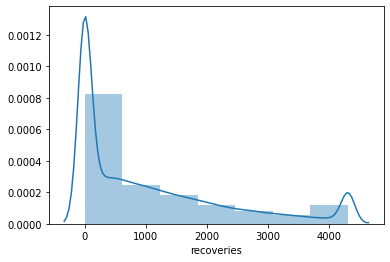

In [77]:
sns.distplot(loan_data['recoveries'], bins=7)

# Modelling Preparation

**Dropping columns as per feature selection results from previous tests**

In [58]:
'''
cols_dropped_post_feature_selection = []
loan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)
'''

'\ncols_dropped_post_feature_selection = []\nloan_data.drop(cols_dropped_post_feature_selection, axis=1, inplace=True)\n'

**Get the feature and target variables**

In [59]:
y = loan_data['recoveries']
X = loan_data.drop(['recoveries'], axis=1)

y_scaled = loan_data_scaled['recoveries']
X_scaled = loan_data_scaled.drop(['recoveries'], axis=1)

print('Now, the dataset has ', X.shape[0], ' records and ', X.shape[1], ' variables.')

Now, the dataset has  268559  records and  67  variables.


**Define k for cross-validation**

In [60]:
skf = StratifiedKFold(n_splits=number_of_splits)
n_split = skf.get_n_splits(X)

**Determine the coefficients**

In [61]:
data_train = pd.concat([X_scaled, y_scaled], axis=1)

regressors = ''
regressors_list = list(X_scaled.columns) 
for idx in np.arange(0, len(regressors_list)):
    if idx == len(regressors_list) - 1:
        regressors = regressors + regressors_list[idx]
    else:
        regressors = regressors + regressors_list[idx] + '+'

regressors = 'recoveries ~ ' + regressors

lm1 = smf.ols(formula= regressors, data = data_train).fit()
lm1.params
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:             recoveries   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     2109.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:18:16   Log-Likelihood:            -2.2588e+06
No. Observations:              268559   AIC:                         4.518e+06
Df Residuals:                  268508   BIC:                         4.518e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# Data Modelling - Linear Regression

**Modelling: Train, Test and Model Assessment**

In [66]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
lin_reg = LinearRegression(normalize=False, n_jobs=4)
lin_reg.fit(X_train, y_train)
## predicting using test data
y_pred = lin_reg.predict(X_test)

In [67]:
#y_pred = np.where(y_pred<0, 0, y_pred) 

**Assessing the model performance**

In [68]:
print('The model intercept: ', lin_reg.intercept_)
print('The model prediction score (r^2): ', lin_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=lin_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  1077.2306189771953
The model prediction score (r^2):  0.2827382220745297
The model prediction score (adjusted r^2):  0.28154326138423214
The model RMSE score:  1092.0525114121406


Text(0.5, 1.0, 'Actual vs Predicted Values')

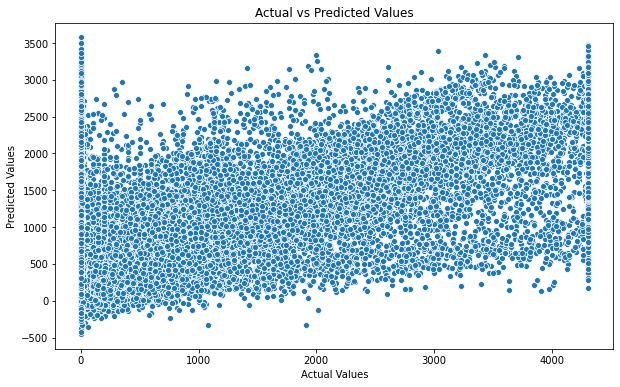

In [69]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Polynomial Regression

**Modelling: Train, Test and Model Assessment**

In [51]:
## define the polynomial degree
poly = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly.fit_transform(X_scaled)
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_poly,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
poly_reg = LinearRegression(normalize=True, n_jobs=4)
poly_reg.fit(X_train, y_train)
## predicting using test data
y_pred = poly_reg.predict(X_test)

In [52]:
print('The model intercept: ', poly_reg.intercept_)
print('The model prediction score (r^2): ', poly_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=poly_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  184403514256794.06
The model prediction score (r^2):  0.3620396654656267
The model prediction score (adjusted r^2):  0.3227245970202597
The model RMSE score:  1026.7293133410708


Text(0.5, 1.0, 'Actual vs Predicted Values')

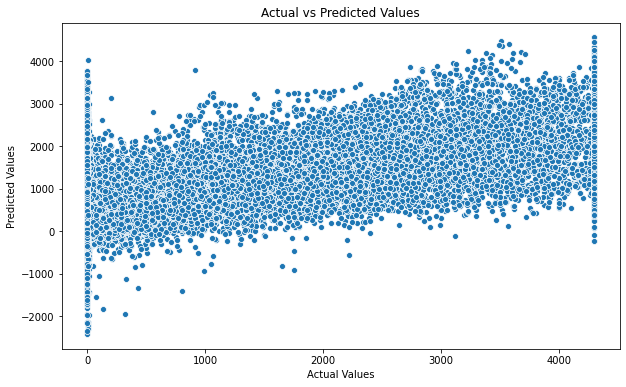

In [53]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Support Vector Regression

**Hyper parameter tuning**

In [49]:
'''
reg = SVR(max_iter=10000)
parameters = {
    'kernel': ['linear'],
    'C': [100],
    'tol': [0.01]
     }

grid = GridSearchCV(clf, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = SVR(max_iter=10000)\nparameters = {\n    'kernel': ['linear'],\n    'C': [100],\n    'tol': [0.01]\n     }\n\ngrid = GridSearchCV(clf, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [50]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
sv_reg = SVR(kernel='linear', C=100, tol=0.01)
sv_reg.fit(X_train, y_train)
## predicting using test data
y_pred = sv_reg.predict(X_test)

**Assessing the model performance**

In [51]:
print('The model intercept: ', sv_reg.intercept_)
print('The model prediction score (r^2): ', sv_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=sv_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  [1196.39308467]
The model prediction score (r^2):  0.7072270178812229
The model prediction score (adjusted r^2):  0.7022885008112435
The model RMSE score:  988.1480151806065


Text(0.5, 1.0, 'Actual vs Predicted Values')

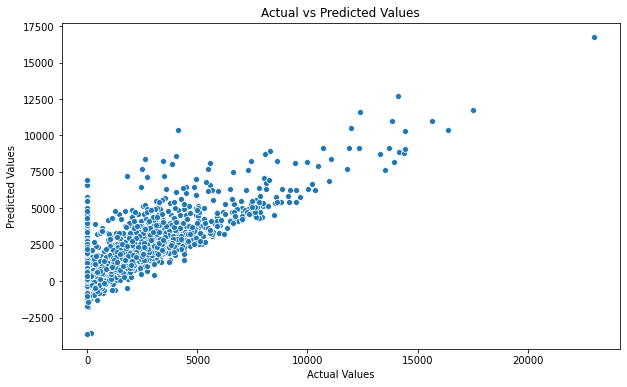

In [52]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Ridge Regression

**Hyper parameter tuning**

In [54]:
'''
reg = Ridge(normalize=False,max_iter=10000,random_state=0)
parameters = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'alpha': [1,10,100,1000],
    'tol': [0.01,0.001,0.0001]
     }

grid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = Ridge(normalize=False,max_iter=10000,random_state=0)\nparameters = {\n    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],\n    'alpha': [1,10,100,1000],\n    'tol': [0.01,0.001,0.0001]\n     }\n\ngrid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [55]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
ridge_reg = Ridge(solver='auto', alpha=1, tol=0.01, normalize=False, max_iter=10000, random_state=0)
ridge_reg.fit(X_train, y_train)
## predicting using test data
y_pred = ridge_reg.predict(X_test)

**Assessing the model performance**

In [56]:
print('The model intercept: ', ridge_reg.intercept_)
print('The model prediction score (r^2): ', ridge_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=ridge_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  1073.2260636989492
The model prediction score (r^2):  0.28809917709486055
The model prediction score (adjusted r^2):  0.28691650030005156
The model RMSE score:  1084.5981774610038


Text(0.5, 1.0, 'Actual vs Predicted Values')

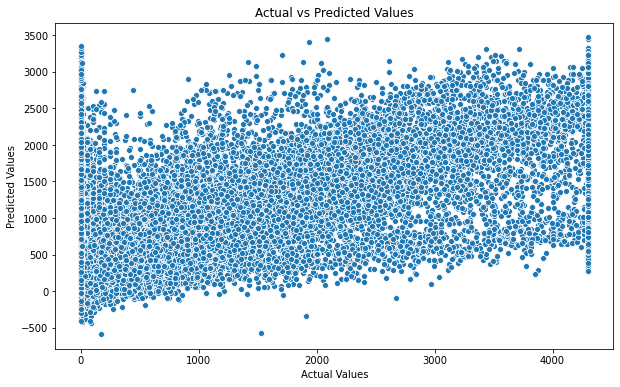

In [57]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Lasso Regression

In [58]:
'''
reg = Lasso(normalize=False,max_iter=10000,random_state=0)
parameters = {
    'selection': ['cyclic','random'],
    'alpha': [1,10,100,1000],
    'tol': [0.01,0.001,0.0001],
    'positive': [True,False]
     }

grid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X_scaled, y_scaled)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = Lasso(normalize=False,max_iter=10000,random_state=0)\nparameters = {\n    'selection': ['cyclic','random'],\n    'alpha': [1,10,100,1000],\n    'tol': [0.01,0.001,0.0001],\n    'positive': [True,False]\n     }\n\ngrid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X_scaled, y_scaled)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

**Modelling: Train, Test and Model Assessment**

In [59]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## model fitting using train data
lasso_reg = Lasso(selection='cyclic', alpha=1, tol=0.0001, normalize=False, max_iter=10000, random_state=0)
lasso_reg.fit(X_train, y_train)
## predicting using test data
y_pred = lasso_reg.predict(X_test)

In [60]:
print('The model intercept: ', lasso_reg.intercept_)
print('The model prediction score (r^2): ', lasso_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=lasso_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model intercept:  1073.2345336835253
The model prediction score (r^2):  0.2881338322931486
The model prediction score (adjusted r^2):  0.28695121307082383
The model RMSE score:  1084.5717781219794


Text(0.5, 1.0, 'Actual vs Predicted Values')

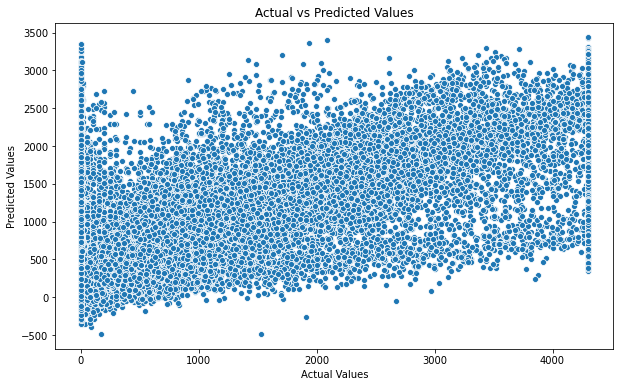

In [61]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Random Forest Regressor

In [62]:
'''
reg = RandomForestRegressor(random_state=0)
parameters = {
    'criterion': ['mse'],
    'max_depth':  [9],
    'min_samples_split':  [2],
    'min_samples_leaf': [1],
    'max_leaf_nodes' : [20],
    'max_features' : ['auto'],
    'n_estimators' : [200]
     }

grid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)
grid.fit(X, y)
print('Best Estimator: ', grid.best_estimator_)
print('Best Score: ', grid.best_score_)
'''

"\nreg = RandomForestRegressor(random_state=0)\nparameters = {\n    'criterion': ['mse'],\n    'max_depth':  [9],\n    'min_samples_split':  [2],\n    'min_samples_leaf': [1],\n    'max_leaf_nodes' : [20],\n    'max_features' : ['auto'],\n    'n_estimators' : [200]\n     }\n\ngrid = GridSearchCV(reg, parameters, n_jobs=4, scoring='r2', cv=2, verbose=20)\ngrid.fit(X, y)\nprint('Best Estimator: ', grid.best_estimator_)\nprint('Best Score: ', grid.best_score_)\n"

In [63]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_data_size,random_state=0)
## model fitting using train data
rf_reg = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, criterion='mse',
                                max_depth=9, max_features='auto', max_leaf_nodes=21, 
                                n_estimators=200, random_state=0, n_jobs=4)
rf_reg.fit(X_train, y_train)
## predicting using test data
y_pred = rf_reg.predict(X_test)

In [64]:
print('The model prediction score (r^2): ', rf_reg.score(X_test, y_test))
print('The model prediction score (adjusted r^2): ', get_adjusted_r_squared(r_sqd=rf_reg.score(X_test, y_test), 
                                                                            N=X_test.shape[0],
                                                                            p=X_test.shape[1]))
print('The model RMSE score: ', get_rmse_score(y_pred, y_test))

The model prediction score (r^2):  0.42896706111525096
The model prediction score (adjusted r^2):  0.42801840733629537
The model RMSE score:  971.3812203472099


Text(0.5, 1.0, 'Actual vs Predicted Values')

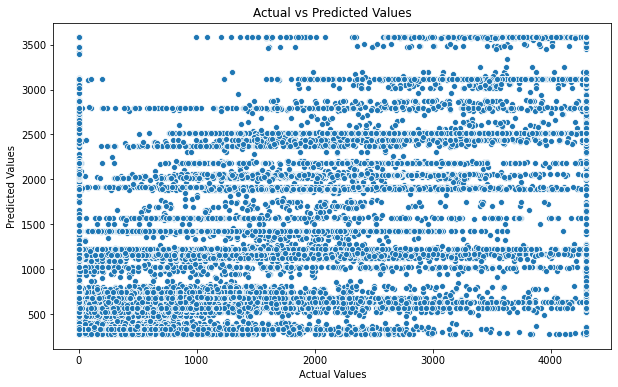

In [65]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Data Modelling - Artificial Neural Network

In [60]:
## split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled,test_size=test_data_size,random_state=0)
## define the model
ann_reg = Sequential()
## build the input layer
ann_reg.add(Dense(32, kernel_initializer='normal', use_bias=True, activation='relu',
                  input_dim = X_train.shape[1]))
## build the hidden layers
ann_reg.add(Dense(32, kernel_initializer='normal', use_bias=True, activation='relu'))
## build the output layers
ann_reg.add(Dense(1, kernel_initializer='normal', use_bias=True, activation='relu'))
## compile the network
opt = optimizers.SGD(lr=0.001)
ann_reg.compile(optimizer=opt, loss='mse',  metrics=['mae','accuracy'])
ann_reg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                2176      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = ann_reg.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
228922/228922 [==============================] - 2s 10us/step - loss: 374361933.4002 - mae: 1376.2964 - accuracy: 0.3112
Epoch 2/10
228922/228922 [==============================] - 2s 8us/step - loss: 2794780.9389 - mae: 1073.2820 - accuracy: 0.3120
Epoch 3/10
228922/228922 [==============================] - 2s 8us/step - loss: 2794780.9330 - mae: 1073.2814 - accuracy: 0.3120
Epoch 4/10
228922/228922 [==============================] - 2s 8us/step - loss: 2794780.9406 - mae: 1073.2823 - accuracy: 0.3120
Epoch 5/10
228922/228922 [==============================] - 2s 9us/step - loss: 2794780.9307 - mae: 1073.2808 - accuracy: 0.3120
Epoch 6/10
228922/228922 [==============================] - 2s 9us/step - loss: 2794780.9358 - mae: 1073.2808 - accuracy: 0.3120
Epoch 7/10
228922/228922 [==============================] - 2s 8us/step - loss: 2794780.9325 - mae: 1073.2816 - accuracy: 0.3120
Epoch 8/10
228922/228922 [==============================] - 2s 9us/step - loss: 2794780.9373 -

In [62]:
## predicting using test data
y_pred = ann_reg.predict(X_test)

In [63]:
score = ann_reg.evaluate(X_test, y_test,verbose=1)
print(score)

40398/40398 [==============================] - 1s 14us/step
[2817365.3587987027, 1079.330078125, 0.30830734968185425]


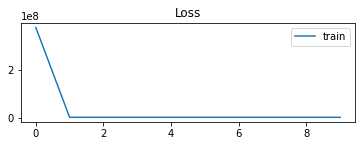

In [64]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()

# Model Performance Summary

<table style="width:50%">
<tr>
<th>Model Name</th>
<th>RMSE</th>
<th>R^2</th>
<th>Adjusted R^2</th>    
</tr>

<tr>
<td>Polynomial Regression</td>
<td>458.87</td>
<td>0.94</td>
<td>0.93</td>
</tr>

<tr>
<td>Linear Regression</td>
<td>1000.69</td>
<td>0.708</td>
<td>0.707</td>
</tr>

<tr>
<td>Lasso Regression</td>
<td>1000.89</td>
<td>0.708</td>
<td>0.707</td>
</tr>

<tr>
<td>Ridge Regression</td>
<td>1207.56</td>
<td>0.708</td>
<td>0.707</td>
</tr>

<tr>
<td>Support Vector Regression</td>
<td>1023.00</td>
<td>0.707</td>
<td>0.702</td>
</tr>

</table>

# Predicting the fate of currently active loans

In [57]:
'''
## preprocessing the data
loan_data_final_predict['issue_d'] = (pd.to_datetime(loan_data_final_predict['issue_d']).dt.year).astype(int)
loan_data_final_predict['emp_length'].fillna(value=0,inplace=True)
loan_data_final_predict['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan_data_final_predict['emp_length'] = loan_data_final_predict['emp_length'].astype(int)
loan_data_final_predict['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)
## dropping columns not needed
loan_data_final_predict.drop(cols_to_be_dropped, axis=1, inplace=True)
## temporary step
for feature in temp_cols_imputed:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data_final_predict[feature].median())
loan_data_final_predict.drop(temp_cols_dropped, axis=1, inplace=True)
## missing value imputation -> constant(zero), mean, median
for feature in cols_for_zero_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 0)
for feature in cols_for_median_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data[feature].median())
## categorical value encoding
for feature in loan_data_final_predict.columns:
    if loan_data_final_predict[feature].dtype == 'object':
        loan_data_final_predict[feature] = encode_categorical_variable(loan_data_final_predict, feature)
## missing value imputation -> knn
for feature in cols_for_knn_imputation:
    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, 
                                                          loan_data_final_predict[feature].mode().get(0))
## missing value imputation -> constant (categorical)
loan_data_final_predict['verification_status_joint'] = impute_by_constant(loan_data_final_predict, 
                                                                          'verification_status_joint', 
                                                                          'Not Applicable')
## categorical value encoding
#loan_data_final_predict = scale_variable(loan_data_final_predict, 'loan_type')
scaler = StandardScaler()
scaler.fit(loan_data_final_predict)
loan_data_final_predict = pd.DataFrame(scaler.transform(loan_data_final_predict), 
                                       columns=loan_data_final_predict.columns)
## predict
y_final_pred = lg_clf.predict(loan_data_final_predict)
## merge predicted values with dataset
loan_data_final_predict['loan_status'] = pd.Series(y_final_pred)
'''

"\n## preprocessing the data\nloan_data_final_predict['issue_d'] = (pd.to_datetime(loan_data_final_predict['issue_d']).dt.year).astype(int)\nloan_data_final_predict['emp_length'].fillna(value=0,inplace=True)\nloan_data_final_predict['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)\nloan_data_final_predict['emp_length'] = loan_data_final_predict['emp_length'].astype(int)\nloan_data_final_predict['emp_length'].replace(to_replace=0, value=np.nan, inplace=True)\n## dropping columns not needed\nloan_data_final_predict.drop(cols_to_be_dropped, axis=1, inplace=True)\n## temporary step\nfor feature in temp_cols_imputed:\n    loan_data_final_predict[feature] = impute_by_constant(loan_data_final_predict, feature, \n                                                          loan_data_final_predict[feature].median())\nloan_data_final_predict.drop(temp_cols_dropped, axis=1, inplace=True)\n## missing value imputation -> constant(zero), mean, median\nfor feature in cols_

In [58]:
'''
## write prdicted values to output file
loan_data_final_predict[loan_data_final_predict['loan_status'] == 0].to_csv('predicted_bad_loans.csv', index=False) 
'''

"\n## write prdicted values to output file\nloan_data_final_predict[loan_data_final_predict['loan_status'] == 0].to_csv('predicted_bad_loans.csv', index=False) \n"